In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# Прочитаем исходные данные
import pandas as pd

data = pd.read_csv("data/ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


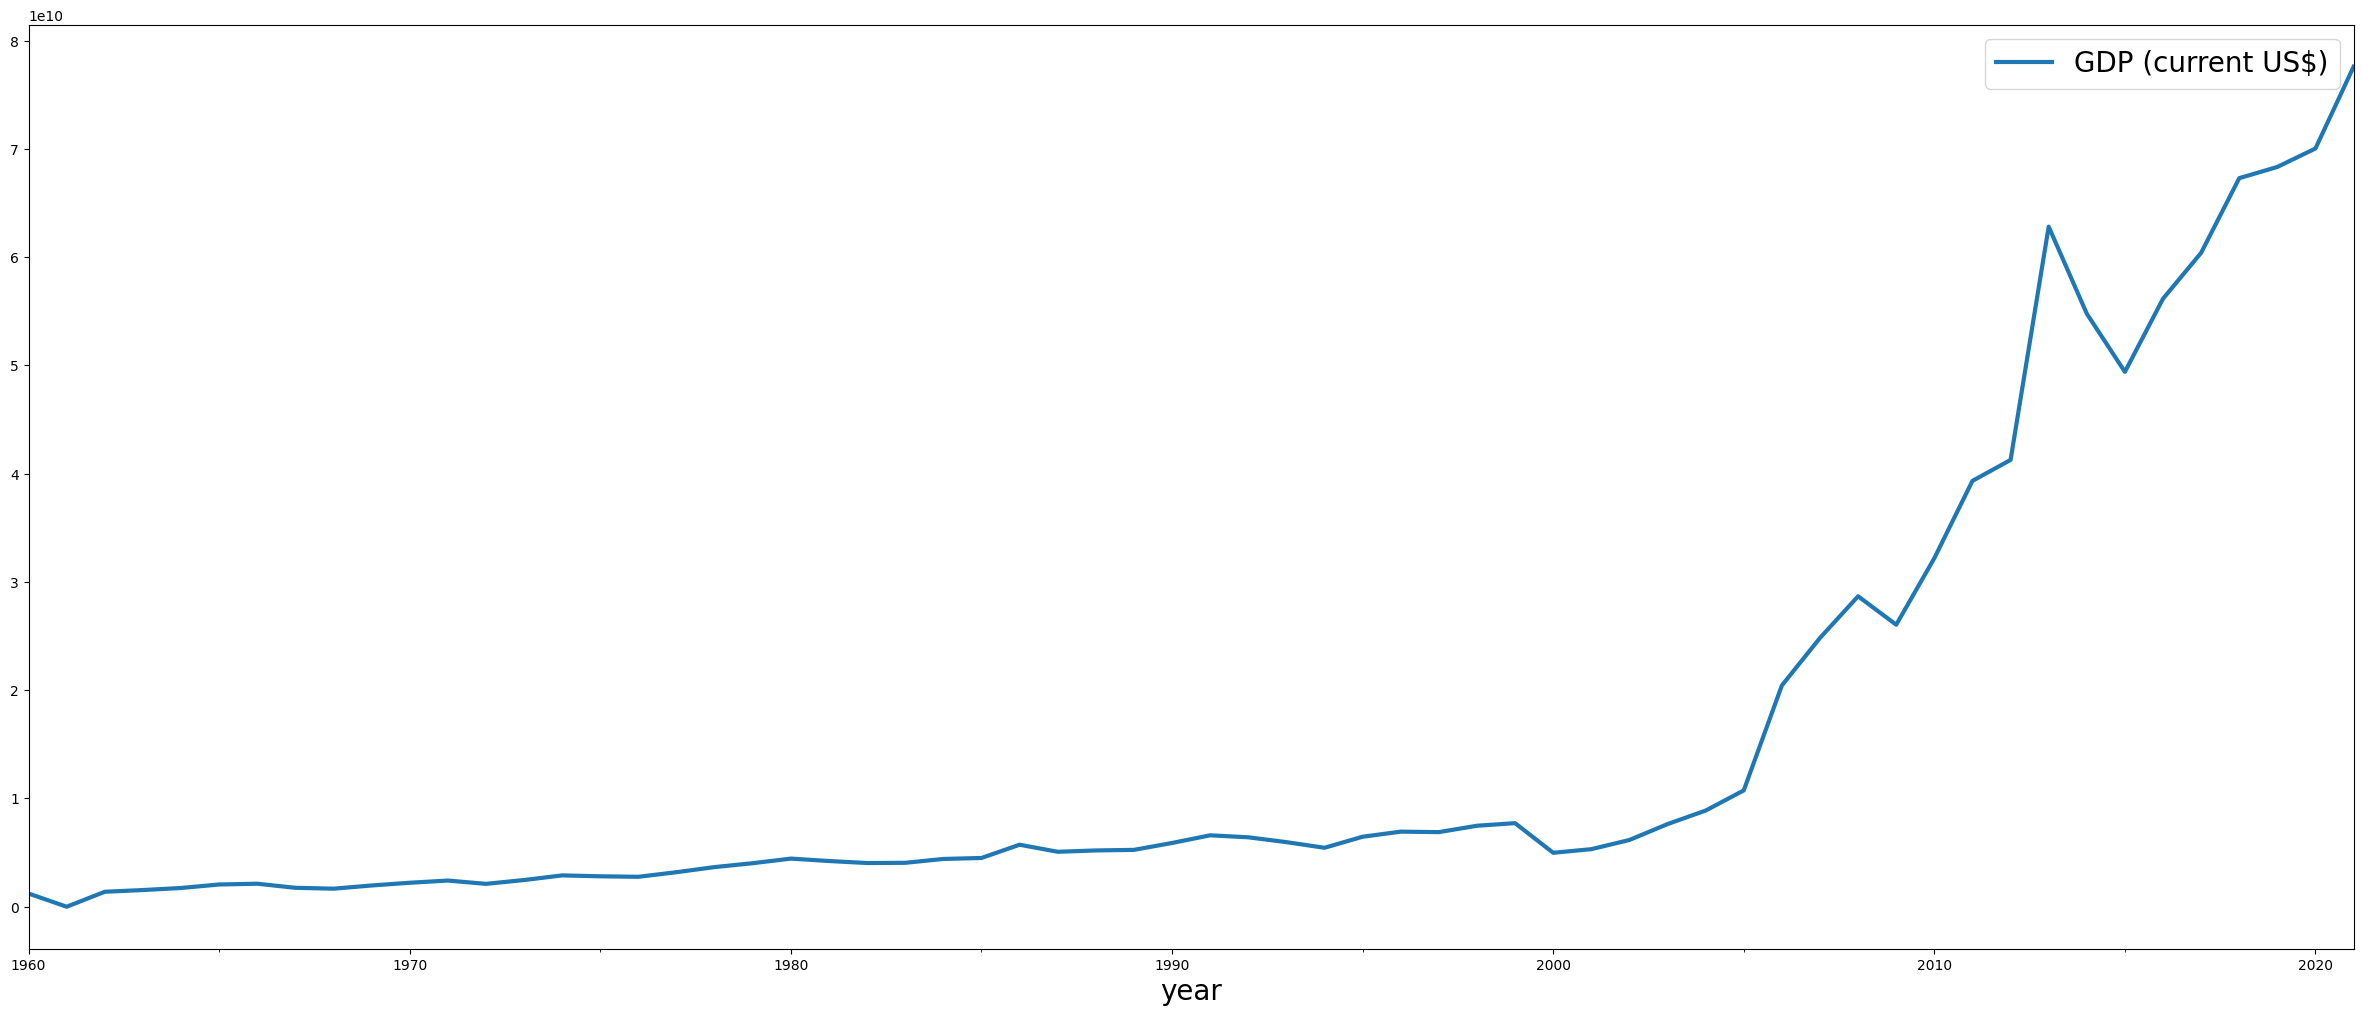

In [3]:
# визуализируем исходный ряд
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()


In [24]:
train_df = data[:-3]
test_df = data[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Первично можно сделать вывод, что наблюдается в данных восходящий тренд. Сезонности пока не наблюдается

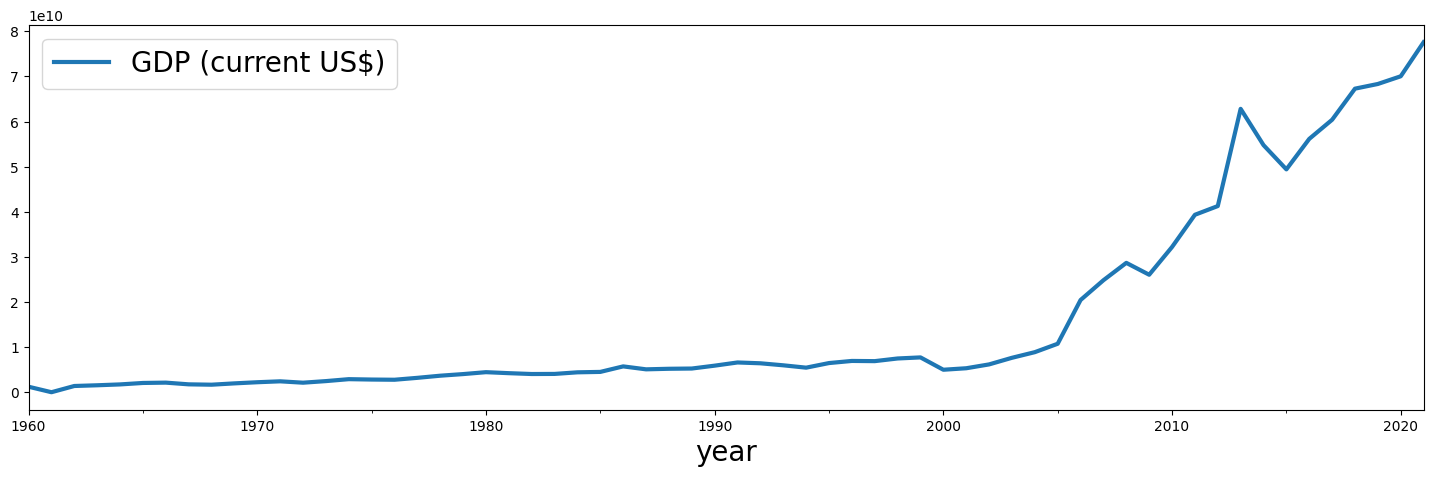

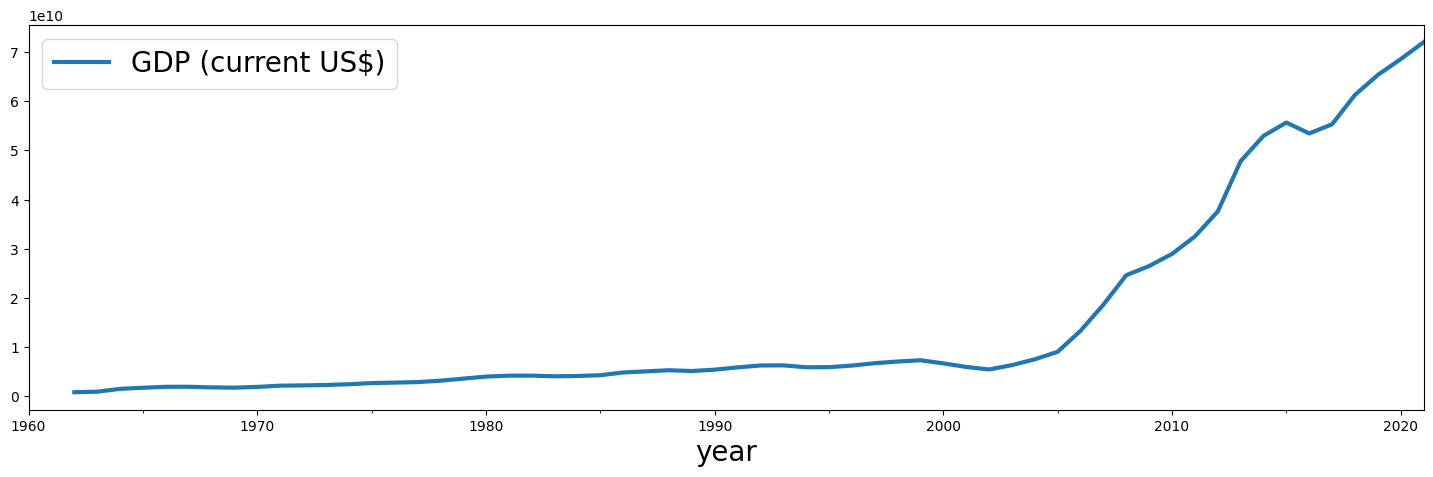

In [25]:
# отразим на едином графике исходный ряд и скользящее среднее разными цветами
data.plot()
data.rolling(3).mean().plot()
plt.show()



При сглаживании окном 3 наблюдается хорошее удаление шумов и выбросов, при этом сохраняется общая тенденция

In [26]:
# проведем тест на стационарность
from statsmodels.tsa.stattools import adfuller

test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [27]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_1 = data.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.587944111800476
p-value:  0.4896467177743541
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [28]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_2 = df_diff_1.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test2 = adfuller(df_diff_2)
print ('adf: ', test2[0])
print ('p-value: ', test2[1])
print ('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.745908762849135
p-value:  0.40762748326075393
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [29]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_3 = df_diff_2.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test3 = adfuller(df_diff_3)
print ('adf: ', test3[0])
print ('p-value: ', test3[1])
print ('Critical values: ', test3[4])
if test3[0]> test3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -5.278476343687468
p-value:  6.066691711555073e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


После третьего дифференцирования ряд стал стационарным. А это значит, что наш параметр d для будущей модели = 3

In [30]:
d = 3

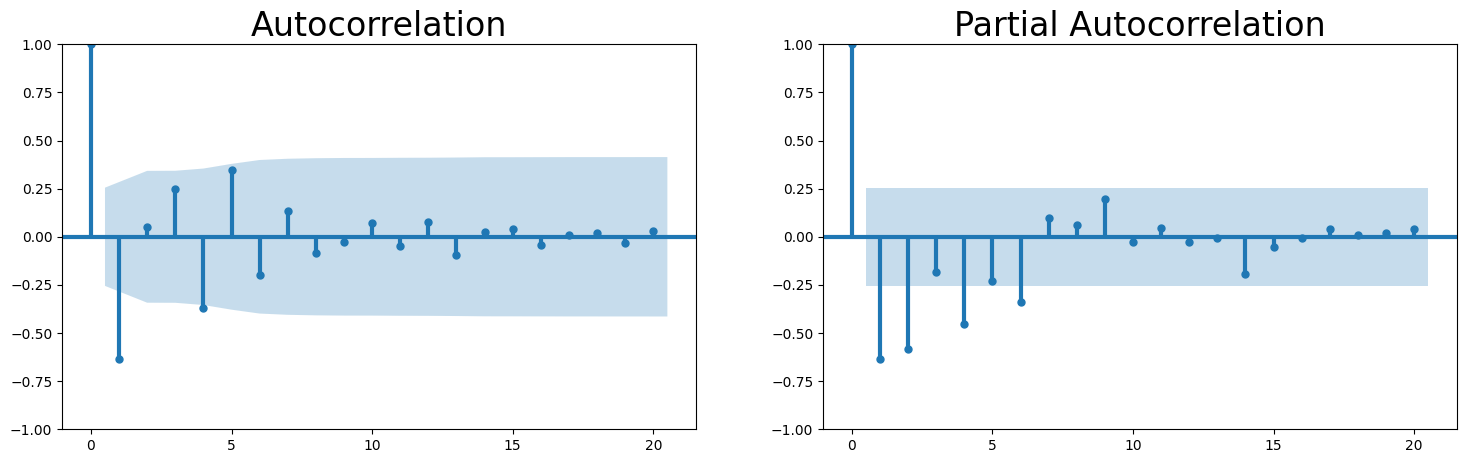

In [31]:
# построим ACF и PACF полученного ряда
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    plot_acf(series, ax=axes[0], lags=20)
    plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

plot_acf_pacf(df_diff_3)

По PACF видим, что последним лагом, отличаюмся от нуля является 2

In [32]:
p = 2

А по ACF последний существенный лаг - 1

In [33]:
q = 1

Сезонности у нас нет, изначальный ряд - нестационарен, поэтому, наш выбор - ARIMA

In [34]:
# построим модель ARIMA с полученными параметрами
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 10 Nov 2023   AIC                           2659.231
Time:                        10:40:31   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

In [15]:
#!pip install pmdarima

In [35]:
# а теперь используем пакет pmdarima для подбора параметров модели
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3, # тут меняем порядок интегрированности
    start_q=1,
    max_p=6,
    max_q=6,
    #D=3, # тут меняем порядок сезонности, а сезонности у нас нет
    #start_P=0,
    #m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.649 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 10 Nov 2023   AIC                           2659.231
Time:                        10:40:44   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Использовали подбор параметров, но выяснили, что наилучшие параметры это те, что мы как раз и выбрали.

In [36]:
# построим модель с лучшими параметрами
arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(2, 3, 1))

arima_model_fit = arima_model.fit()
arima_model_fit.summary()



c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 10 Nov 2023   AIC                           2659.231
Time:                        10:41:59   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

In [45]:
# выполним предсказание на тестовом наборе данных

pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[2]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

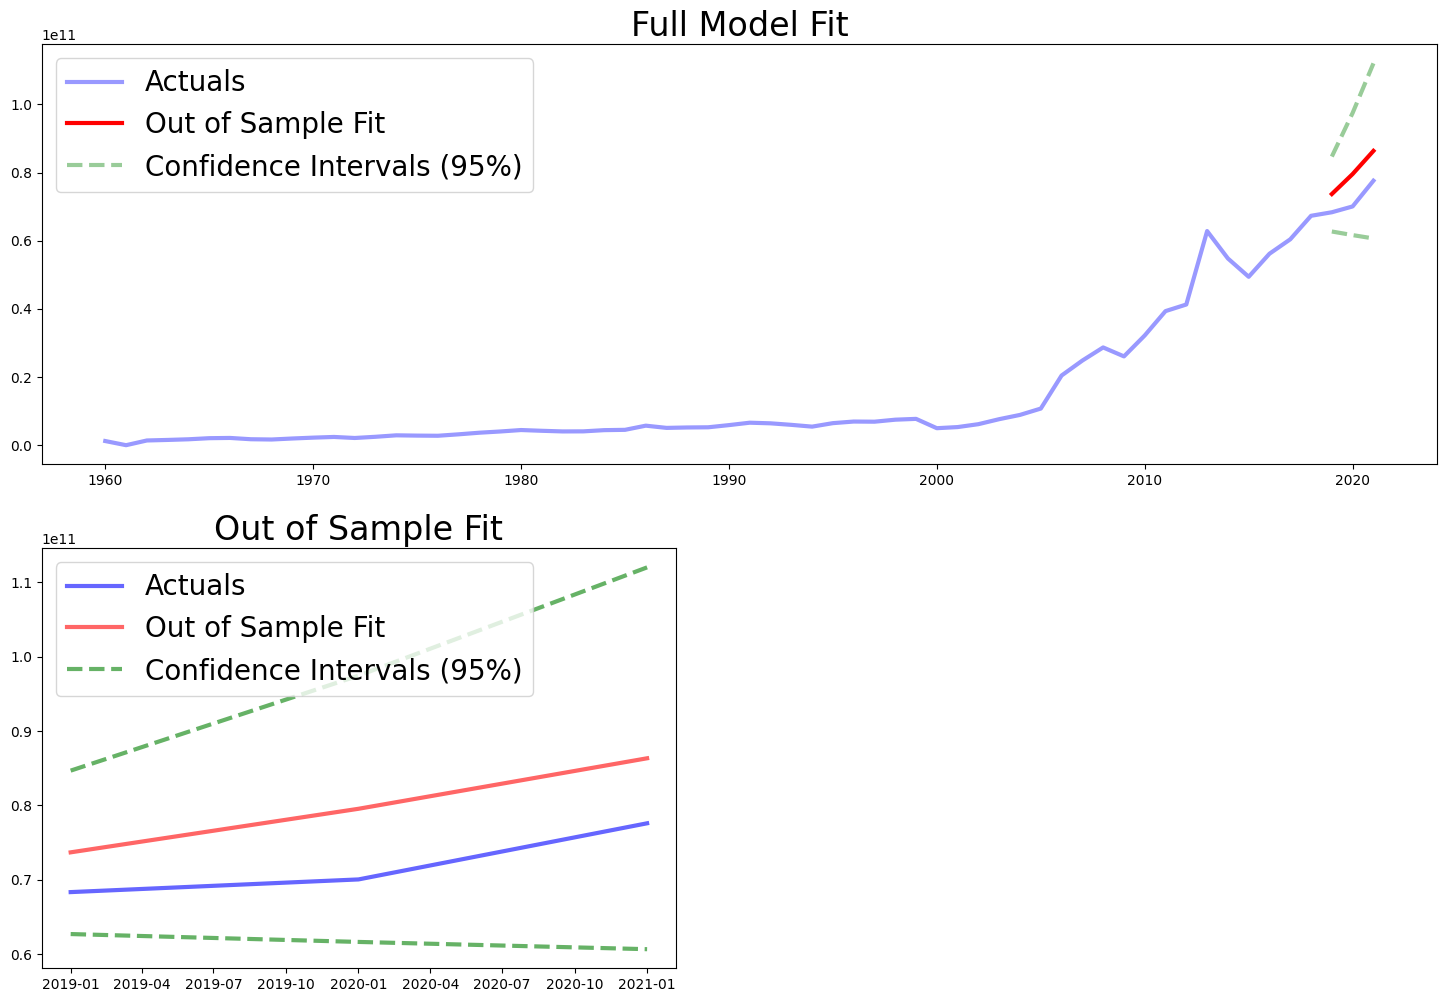

In [46]:
# отобразим результат графически

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()


In [51]:
# Хочу посмотреть еще на метрику MAPE
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(pred_df.loc[test_df.index]["GDP (current US$)"], pred_df.loc[test_df.index]["model_preds"]) * 100

10.887748622973225

Неплохо. Предсказание отклоняется от реального на 10%. Общая тенденция роста так-же отображена хорошо.

In [60]:
# проверим данные на наличие пропущенных дат
data.asfreq(freq='AS').index.isnull().sum()


0

Пропусков в данных нет

In [61]:
# найдём нулевые значения
data[data['GDP (current US$)'] == 0]


,GDP (current US$)
year,
1961-01-01,0.0


Нулевое значение заменим NaN

In [63]:
import numpy as np
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

Интерполируем

In [66]:
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')
data.head(3)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09


Снова попробуем построить модель с интерполированными данными

In [67]:
train_df = data[:-3]
test_df = data[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [68]:
# проведем тест на стационарность
from statsmodels.tsa.stattools import adfuller

test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [69]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_1 = data.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.7397184892921593
p-value:  0.41077316906677114
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [70]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_2 = df_diff_1.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test2 = adfuller(df_diff_2)
print ('adf: ', test2[0])
print ('p-value: ', test2[1])
print ('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.7042548913504119
p-value:  0.4289215730117663
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [71]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_3 = df_diff_2.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test3 = adfuller(df_diff_3)
print ('adf: ', test3[0])
print ('p-value: ', test3[1])
print ('Critical values: ', test3[4])
if test3[0]> test3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -5.456208629828435
p-value:  2.578324497204482e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


In [72]:
d = 3

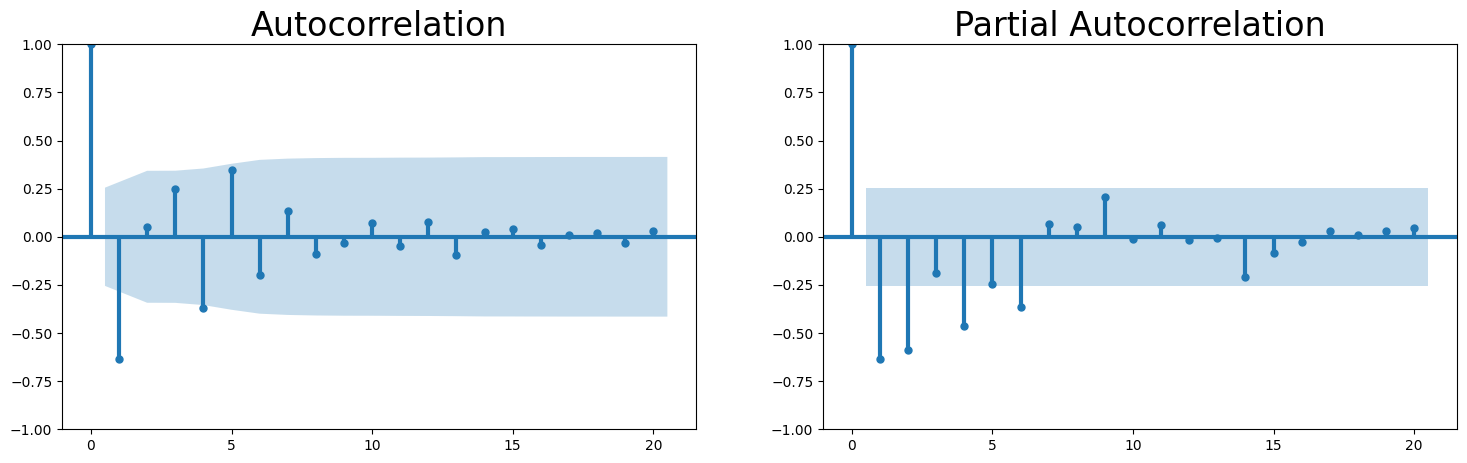

In [73]:
# построим ACF и PACF полученного ряда
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    plot_acf(series, ax=axes[0], lags=20)
    plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

plot_acf_pacf(df_diff_3)

Неожиданностей нет, значения остались прежними

In [74]:
q = 1
p = 2

In [75]:
# построим модель ARIMA с полученными параметрами
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Fri, 10 Nov 2023   AIC                           2659.226
Time:                        16:19:16   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

Интерполированные данные позволили нам чуть-чуть улучшить модель

## Волатильность

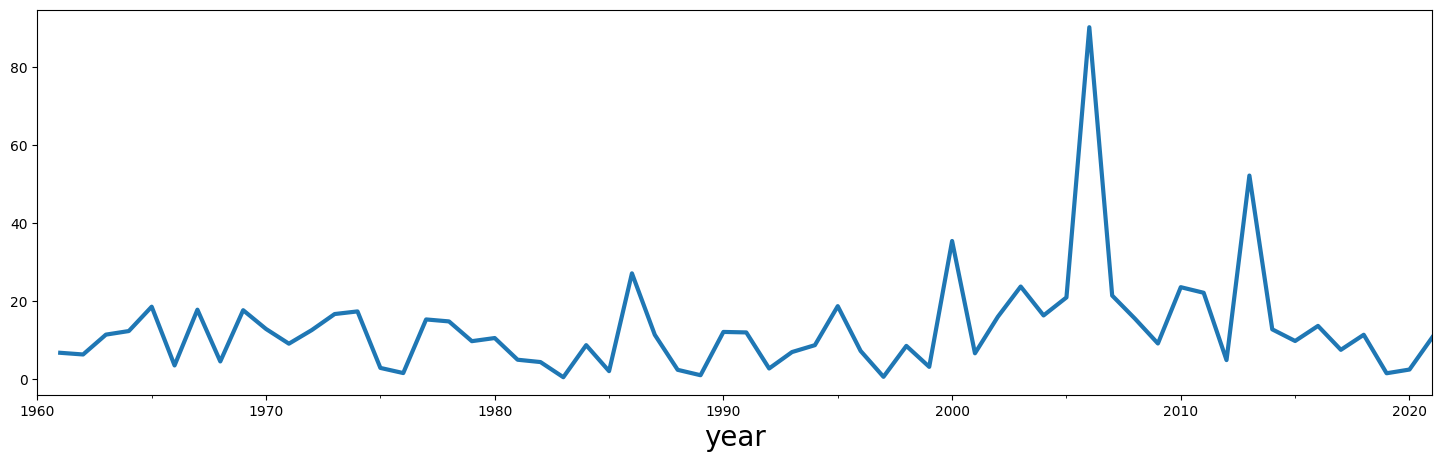

In [80]:
# для начала, изобразим график волатильности

data["gdp_vol"] = data["GDP (current US$)"].pct_change(1).mul(100).abs()
data["gdp_vol"].plot()
plt.show()

In [81]:
train_df = data[:-3]
test_df = data[-3:]
train_df.shape, test_df.shape

((59, 2), (3, 2))

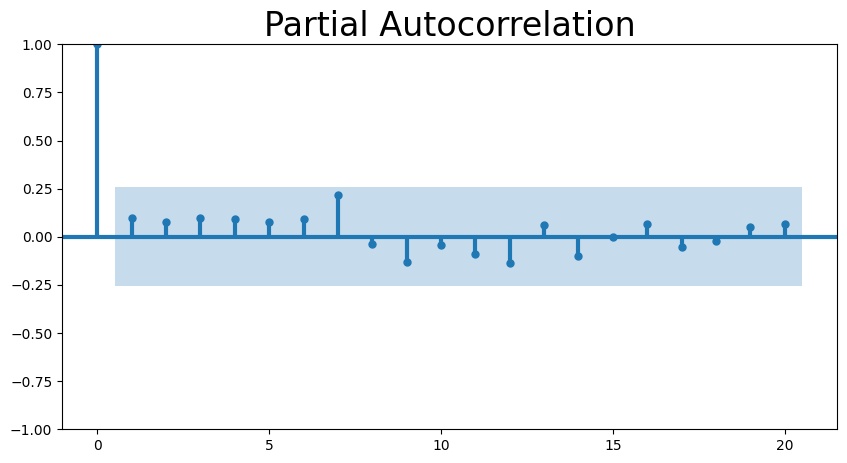

In [83]:
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df['gdp_vol'][1:], lags=20, method="ywm")
plt.show()

По PACF получается, что лагов, существенно отличающихся от нуля - нет.

In [85]:
# проверим статичность ряда

adfuller(train_df['gdp_vol'][1:])


(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд статичен

In [100]:
# Используем модель GARCH 1,0
from arch import arch_model

garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index])

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

model = arch_model(garch_df["gdp_vol"].dropna(), p=1, q=0)


# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     21,   Neg. LLF: 232.56315363715478
Iteration:     10,   Func. Count:     41,   Neg. LLF: 232.55982411365196
Optimization terminated successfully    (Exit mode 0)
            Current function value: 232.55851615925837
            Iterations: 14
            Function evaluations: 57
            Gradient evaluations: 14


In [101]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -232.559
Distribution:                  Normal   AIC:                           471.117
Method:            Maximum Likelihood   BIC:                           477.298
                                        No. Observations:                   58
Date:                Mon, Nov 13 2023   Df Residuals:                       57
Time:                        15:27:12   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.9013      1.893      5.757  8.548e-09 [  7.190, 14.612]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         95.0938    197.808      0.481      0.631 [-2.926e+02,4.828e+02]
alpha[1]       1.0000      2.233      0.448      0.654      [ -3.377,  5.377]
=============================================================================

Covariance estimator: robust
"""

In [102]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

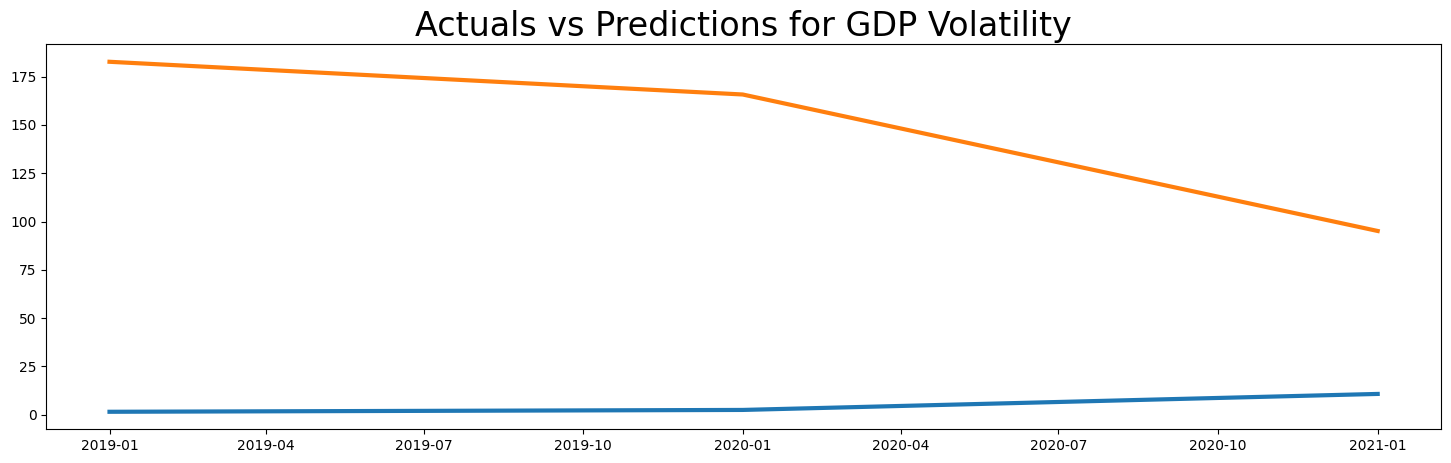

In [103]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

In [104]:
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
)

22190.26319060966

Построим линейную регрессию для сравнения

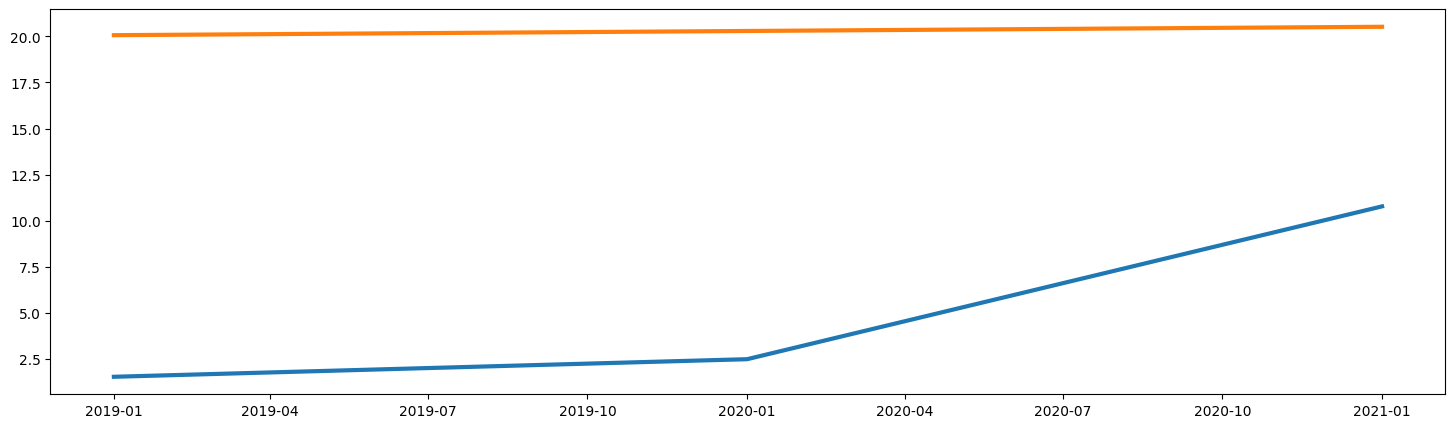

In [105]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Линейная модель "справилась" лучше, если это можно так назвать. GARCH-модель вообще не уловила направление движения, показав уменьшение, вместо увеличения. Абсолютная ошибка так--же выше у GARCH-модели

Мне кажется, что использовать подобное исследование и предсказание на таком малом объеме тестовой и тренировочной выборке - бессмысленно. А во вторых - изначально волатильность уже была похожа на "белый шум", за исключением одного выброса. Можно было обойтись линейной регрессией для значения волатильности, или даже фиксированным числом.